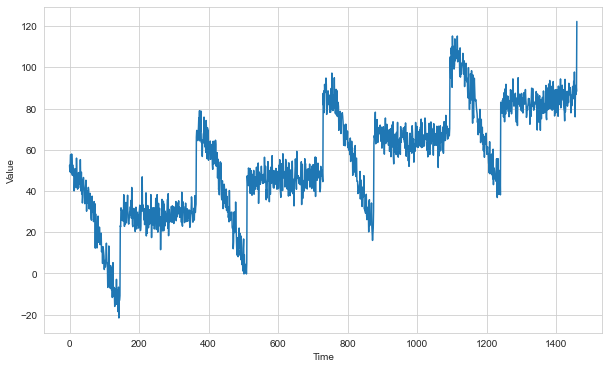

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras


def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40



series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise




plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [2]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [5]:
train_set = sequential_window_dataset(X_train,window_size)

In [6]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [9]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [10]:
reset_states = ResetStatesCallback()

In [11]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [12]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 3s 11ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 11ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 11ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

33/33 [==============================] - 0s 12ms/step - loss: 18.9170 - mae: 19.4122
Epoch 86/100
33/33 [==============================] - 0s 12ms/step - loss: 19.2816 - mae: 19.7755
Epoch 87/100
33/33 [==============================] - 0s 13ms/step - loss: 17.9223 - mae: 18.4160
Epoch 88/100
33/33 [==============================] - 0s 11ms/step - loss: 24.5973 - mae: 25.0949
Epoch 89/100
33/33 [==============================] - 0s 13ms/step - loss: 33.7440 - mae: 34.2400
Epoch 90/100
33/33 [==============================] - 0s 11ms/step - loss: 26.8697 - mae: 27.3621
Epoch 91/100
33/33 [==============================] - 1s 16ms/step - loss: 30.6367 - mae: 31.1345
Epoch 92/100
33/33 [==============================] - 0s 12ms/step - loss: 32.7565 - mae: 33.2531
Epoch 93/100
33/33 [==============================] - 0s 12ms/step - loss: 36.6437 - mae: 37.1404
Epoch 94/100
33/33 [==============================] - 0s 12ms/step - loss: 46.4108 - mae: 46.9088
Epoch 95/100
33/33 [=============

(1e-08, 0.0001, 0.0, 30.0)

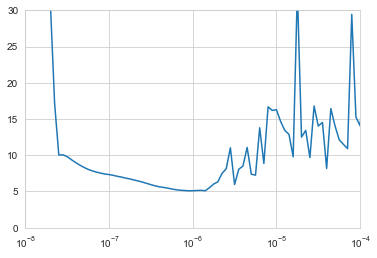

In [13]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [14]:
# Second

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [17]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [19]:
reset_states = ResetStatesCallback()

In [20]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [21]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [22]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 3s 31ms/step - loss: 49.2263 - mae: 49.7226 - val_loss: 19.2765 - val_mae: 19.7735
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 18.2817 - mae: 18.7750 - val_loss: 10.5057 - val_mae: 11.0002
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 12.3929 - mae: 12.8845 - val_loss: 8.5281 - val_mae: 9.0119
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 15.2863 - mae: 15.7806 - val_loss: 26.3586 - val_mae: 26.8586
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 11.1405 - mae: 11.6325 - val_loss: 11.5974 - val_mae: 12.0872
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 17.5335 - mae: 18.0299 - val_loss: 14.6961 - val_mae: 15.1901
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 9.7759 - mae: 10.2660 - val_loss: 8.8089 - val_mae: 9.2981
Epoch 8/500
33/33 [==============================] - 

33/33 [==============================] - 0s 12ms/step - loss: 6.2932 - mae: 6.7813 - val_loss: 7.7863 - val_mae: 8.2673
Epoch 63/500
33/33 [==============================] - 0s 13ms/step - loss: 5.5782 - mae: 6.0575 - val_loss: 5.9056 - val_mae: 6.3885
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 5.4740 - mae: 5.9559 - val_loss: 5.5348 - val_mae: 6.0183
Epoch 65/500
33/33 [==============================] - 0s 11ms/step - loss: 5.3855 - mae: 5.8634 - val_loss: 5.2726 - val_mae: 5.7458
Epoch 66/500
33/33 [==============================] - 0s 13ms/step - loss: 6.2157 - mae: 6.7036 - val_loss: 7.4954 - val_mae: 7.9777
Epoch 67/500
33/33 [==============================] - 0s 13ms/step - loss: 5.6084 - mae: 6.0861 - val_loss: 5.6246 - val_mae: 6.1052
Epoch 68/500
33/33 [==============================] - 0s 13ms/step - loss: 5.5143 - mae: 5.9947 - val_loss: 5.6078 - val_mae: 6.0860
Epoch 69/500
33/33 [==============================] - 0s 15ms/step - loss: 5.6301 

33/33 [==============================] - 0s 11ms/step - loss: 5.3216 - mae: 5.8037 - val_loss: 7.7223 - val_mae: 8.2031
Epoch 124/500
33/33 [==============================] - 0s 12ms/step - loss: 5.0064 - mae: 5.4907 - val_loss: 5.9101 - val_mae: 6.3934
Epoch 125/500
33/33 [==============================] - 0s 12ms/step - loss: 4.9397 - mae: 5.4178 - val_loss: 6.5808 - val_mae: 7.0677
Epoch 126/500
33/33 [==============================] - 0s 13ms/step - loss: 4.9547 - mae: 5.4368 - val_loss: 6.0627 - val_mae: 6.5414
Epoch 127/500
33/33 [==============================] - 0s 11ms/step - loss: 4.8997 - mae: 5.3783 - val_loss: 5.7682 - val_mae: 6.2481
Epoch 128/500
33/33 [==============================] - 0s 13ms/step - loss: 5.0462 - mae: 5.5316 - val_loss: 5.7558 - val_mae: 6.2365
Epoch 129/500
33/33 [==============================] - 0s 12ms/step - loss: 4.7924 - mae: 5.2693 - val_loss: 5.2601 - val_mae: 5.7413
Epoch 130/500
33/33 [==============================] - 0s 12ms/step - loss: 

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

In [25]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

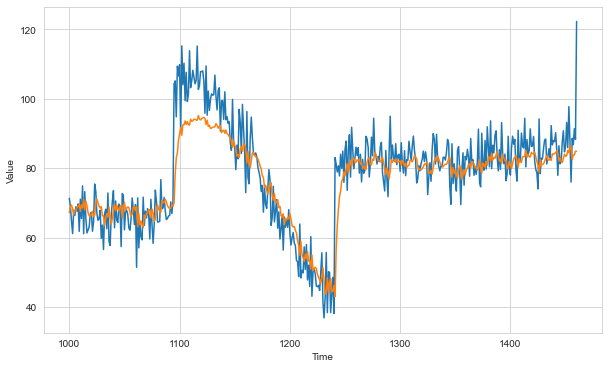

In [26]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)


train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [28]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [29]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [30]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [31]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 19ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 85.9241 - mae: 86.4234
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 82.4702 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 80.2434 - mae: 80.7428
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 72.4508 - mae: 72.9504
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 18ms/step - loss: 8.9986 - mae: 9.4870
Epoch 88/100
8/8 [==============================] - 0s 18ms/step - loss: 10.4007 - mae: 10.8922
Epoch 89/100
8/8 [==============================] - 0s 19ms/step - loss: 9.7538 - mae: 10.2433
Epoch 90/100
8/8 [==============================] - 0s 20ms/step - loss: 14.0814 - mae: 14.5752
Epoch 91/100
8/8 [==============================] - 0s 18ms/step - loss: 29.0200 - mae: 29.5180
Epoch 92/100
8/8 [==============================] - 0s 18ms/step - loss: 19.4787 - mae: 19.9741
Epoch 93/100
8/8 [==============================] - 0s 19ms/step - loss: 20.6903 - mae: 21.1855
Epoch 94/100
8/8 [==============================] - 0s 18ms/step - loss: 17.2046 - mae: 17.6981
Epoch 95/100
8/8 [==============================] - 0s 19ms/step - loss: 15.3465 - mae: 15.8398
Epoch 96/100
8/8 [==============================] - 0s 18ms/step - loss: 16.3757 - mae: 16.8697
Epoch 97/100
8/8 [==============================] - 0s 1

(1e-08, 0.0001, 0.0, 30.0)

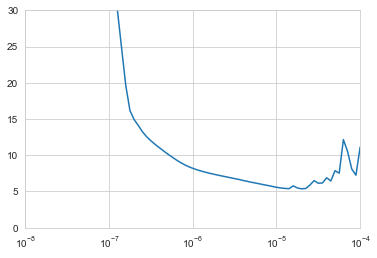

In [32]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [33]:
# SEcond

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [35]:
window_size = 30

In [36]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [37]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [38]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [39]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [40]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 128ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 35ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 34ms/step - loss: 17.3630 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 34ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 31ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 33ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 0s 32ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 33ms/step - 

8/8 [==============================] - 0s 31ms/step - loss: 4.5189 - mae: 4.9947 - val_loss: 6.3860 - val_mae: 6.8701
Epoch 64/500
8/8 [==============================] - 0s 31ms/step - loss: 4.5203 - mae: 4.9967 - val_loss: 6.6531 - val_mae: 7.1365
Epoch 65/500
8/8 [==============================] - 0s 31ms/step - loss: 4.5504 - mae: 5.0274 - val_loss: 5.9734 - val_mae: 6.4555
Epoch 66/500
8/8 [==============================] - 0s 33ms/step - loss: 4.5614 - mae: 5.0384 - val_loss: 6.2281 - val_mae: 6.7109
Epoch 67/500
8/8 [==============================] - 0s 31ms/step - loss: 4.5188 - mae: 4.9957 - val_loss: 6.5304 - val_mae: 7.0145
Epoch 68/500
8/8 [==============================] - 0s 31ms/step - loss: 4.5129 - mae: 4.9895 - val_loss: 6.1017 - val_mae: 6.5841
Epoch 69/500
8/8 [==============================] - 0s 30ms/step - loss: 4.4907 - mae: 4.9673 - val_loss: 6.2080 - val_mae: 6.6916
Epoch 70/500
8/8 [==============================] - 0s 31ms/step - loss: 4.4814 - mae: 4.9571 - 

8/8 [==============================] - 0s 43ms/step - loss: 4.2980 - mae: 4.7725 - val_loss: 5.6938 - val_mae: 6.1760
Epoch 126/500
8/8 [==============================] - 0s 42ms/step - loss: 4.2996 - mae: 4.7740 - val_loss: 5.6642 - val_mae: 6.1458
Epoch 127/500
8/8 [==============================] - 0s 49ms/step - loss: 4.2928 - mae: 4.7677 - val_loss: 5.7806 - val_mae: 6.2632
Epoch 128/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2913 - mae: 4.7661 - val_loss: 5.5420 - val_mae: 6.0215
Epoch 129/500
8/8 [==============================] - 0s 36ms/step - loss: 4.2916 - mae: 4.7659 - val_loss: 5.6051 - val_mae: 6.0865
Epoch 130/500
8/8 [==============================] - 0s 33ms/step - loss: 4.2933 - mae: 4.7673 - val_loss: 5.7362 - val_mae: 6.2186
Epoch 131/500
8/8 [==============================] - 0s 34ms/step - loss: 4.2942 - mae: 4.7688 - val_loss: 5.6332 - val_mae: 6.1152
Epoch 132/500
8/8 [==============================] - 0s 37ms/step - loss: 4.2888 - mae: 4.

8/8 [==============================] - 0s 56ms/step - loss: 4.1816 - mae: 4.6547 - val_loss: 5.5442 - val_mae: 6.0260
Epoch 188/500
8/8 [==============================] - 0s 47ms/step - loss: 4.1780 - mae: 4.6511 - val_loss: 5.3175 - val_mae: 5.7970
Epoch 189/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1821 - mae: 4.6557 - val_loss: 5.4117 - val_mae: 5.8923
Epoch 190/500
8/8 [==============================] - 0s 51ms/step - loss: 4.1827 - mae: 4.6560 - val_loss: 5.3710 - val_mae: 5.8513
Epoch 191/500
8/8 [==============================] - 0s 34ms/step - loss: 4.1821 - mae: 4.6561 - val_loss: 5.6392 - val_mae: 6.1211
Epoch 192/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1799 - mae: 4.6537 - val_loss: 5.5040 - val_mae: 5.9857
Epoch 193/500
8/8 [==============================] - 0s 33ms/step - loss: 4.1767 - mae: 4.6499 - val_loss: 5.6961 - val_mae: 6.1776
Epoch 194/500
8/8 [==============================] - 0s 32ms/step - loss: 4.1734 - mae: 4.

8/8 [==============================] - 0s 46ms/step - loss: 4.1207 - mae: 4.5923 - val_loss: 5.2875 - val_mae: 5.7681
Epoch 250/500
8/8 [==============================] - 0s 51ms/step - loss: 4.1206 - mae: 4.5931 - val_loss: 5.3454 - val_mae: 5.8261
Epoch 251/500
8/8 [==============================] - 0s 50ms/step - loss: 4.1197 - mae: 4.5919 - val_loss: 5.2536 - val_mae: 5.7331
Epoch 252/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1180 - mae: 4.5904 - val_loss: 5.1687 - val_mae: 5.6478
Epoch 253/500
8/8 [==============================] - 0s 36ms/step - loss: 4.1136 - mae: 4.5853 - val_loss: 5.1596 - val_mae: 5.6382
Epoch 254/500
8/8 [==============================] - 0s 39ms/step - loss: 4.1226 - mae: 4.5953 - val_loss: 5.1759 - val_mae: 5.6542
Epoch 255/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1132 - mae: 4.5852 - val_loss: 5.3377 - val_mae: 5.8188
Epoch 256/500
8/8 [==============================] - 0s 40ms/step - loss: 4.1097 - mae: 4.

8/8 [==============================] - 1s 101ms/step - loss: 4.0843 - mae: 4.5560 - val_loss: 5.3270 - val_mae: 5.8080
Epoch 312/500
8/8 [==============================] - 1s 109ms/step - loss: 4.0889 - mae: 4.5604 - val_loss: 5.0733 - val_mae: 5.5524
Epoch 313/500
8/8 [==============================] - 1s 117ms/step - loss: 4.1018 - mae: 4.5743 - val_loss: 5.0705 - val_mae: 5.5479
Epoch 314/500
8/8 [==============================] - 1s 114ms/step - loss: 4.0933 - mae: 4.5650 - val_loss: 5.1203 - val_mae: 5.5991
Epoch 315/500
8/8 [==============================] - 1s 116ms/step - loss: 4.0764 - mae: 4.5475 - val_loss: 5.3249 - val_mae: 5.8058
Epoch 316/500
8/8 [==============================] - 1s 116ms/step - loss: 4.0818 - mae: 4.5535 - val_loss: 5.3326 - val_mae: 5.8136
Epoch 317/500
8/8 [==============================] - 1s 96ms/step - loss: 4.0877 - mae: 4.5600 - val_loss: 5.2706 - val_mae: 5.7511
Epoch 318/500
8/8 [==============================] - 1s 96ms/step - loss: 4.0710 - m

Epoch 373/500
8/8 [==============================] - 1s 116ms/step - loss: 4.0490 - mae: 4.5200 - val_loss: 5.0129 - val_mae: 5.4918
Epoch 374/500
8/8 [==============================] - 1s 114ms/step - loss: 4.0528 - mae: 4.5233 - val_loss: 5.1371 - val_mae: 5.6168
Epoch 375/500
8/8 [==============================] - 1s 124ms/step - loss: 4.0749 - mae: 4.5465 - val_loss: 5.5695 - val_mae: 6.0494
Epoch 376/500
8/8 [==============================] - 1s 113ms/step - loss: 4.0958 - mae: 4.5683 - val_loss: 5.3618 - val_mae: 5.8427
Epoch 377/500
8/8 [==============================] - 1s 111ms/step - loss: 4.0638 - mae: 4.5351 - val_loss: 5.2856 - val_mae: 5.7658
Epoch 378/500
8/8 [==============================] - 1s 119ms/step - loss: 4.0520 - mae: 4.5229 - val_loss: 5.2587 - val_mae: 5.7394
Epoch 379/500
8/8 [==============================] - 1s 110ms/step - loss: 4.0672 - mae: 4.5387 - val_loss: 5.3635 - val_mae: 5.8447
Epoch 380/500
8/8 [==============================] - 1s 116ms/step - 

In [41]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [42]:
model = keras.models.load_model("my_checkpoint.h5")

In [43]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

In [44]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [45]:
rnn_forecast

array([ 63.45312 ,  66.62202 ,  67.25717 ,  66.57254 ,  66.130844,
        67.52234 ,  67.71833 ,  67.93926 ,  67.179   ,  67.258194,
        66.95122 ,  67.36315 ,  68.3338  ,  68.43657 ,  67.1755  ,
        68.40016 ,  67.63731 ,  66.83841 ,  65.18516 ,  66.13109 ,
        66.10493 ,  66.47237 ,  65.53724 ,  65.12647 ,  66.51692 ,
        67.78493 ,  66.93117 ,  66.19904 ,  68.2221  ,  68.70292 ,
        67.18615 ,  66.197586,  65.13584 ,  65.551445,  64.77487 ,
        64.88008 ,  63.933002,  63.98873 ,  63.096664,  63.859715,
        65.48716 ,  65.72564 ,  64.47909 ,  66.00545 ,  66.73195 ,
        67.50942 ,  67.15793 ,  68.58846 ,  66.69275 ,  66.520874,
        68.20898 ,  67.62517 ,  65.74692 ,  67.08102 ,  68.067696,
        67.14231 ,  66.968315,  67.163414,  67.36446 ,  67.63398 ,
        66.419464,  67.15392 ,  64.51324 ,  64.07734 ,  63.88999 ,
        63.176327,  60.921955,  62.52663 ,  62.165863,  63.308174,
        62.986225,  62.87559 ,  65.22581 ,  65.61665 ,  65.657

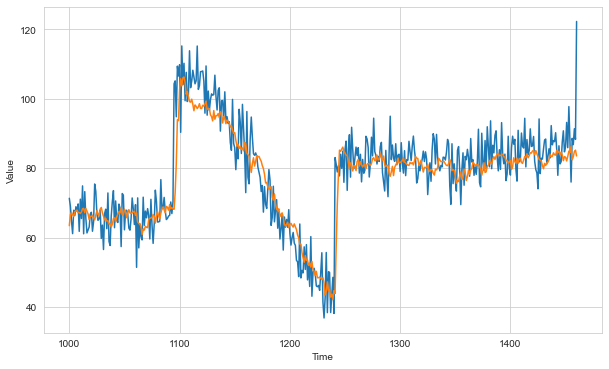

In [46]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [48]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [51]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [53]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [54]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 86ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 1s 86ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 1s 86ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 1s 89ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 1s 85ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 1s 83ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 1s 83ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 1s 79ms/step - loss: 36.6836 - mae: 37.1823
Epoch 9/100
8/8 [==============================] - 1s 92ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 1s 86ms/step - loss: 27.9450 - mae: 28.4427
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 1s 58ms/step - loss: 9.6991 - mae: 10.1881
Epoch 88/100
8/8 [==============================] - 1s 58ms/step - loss: 9.5162 - mae: 10.0045
Epoch 89/100
8/8 [==============================] - 1s 61ms/step - loss: 9.8352 - mae: 10.3240
Epoch 90/100
8/8 [==============================] - 1s 59ms/step - loss: 8.8923 - mae: 9.3802
Epoch 91/100
8/8 [==============================] - 1s 58ms/step - loss: 10.3600 - mae: 10.8495
Epoch 92/100
8/8 [==============================] - 1s 57ms/step - loss: 8.9503 - mae: 9.4391
Epoch 93/100
8/8 [==============================] - 1s 58ms/step - loss: 8.4551 - mae: 8.9437
Epoch 94/100
8/8 [==============================] - 1s 57ms/step - loss: 9.5269 - mae: 10.0164
Epoch 95/100
8/8 [==============================] - 1s 58ms/step - loss: 8.6874 - mae: 9.1748
Epoch 96/100
8/8 [==============================] - 1s 58ms/step - loss: 11.6989 - mae: 12.1901
Epoch 97/100
8/8 [==============================] - 1s 60ms/step 

(0.0001, 0.1, 0.0, 30.0)

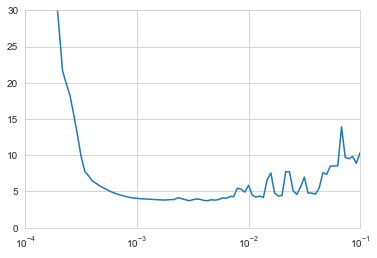

In [55]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [57]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [58]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [59]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [60]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 186ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 94ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 1s 92ms/step - loss: 35.1358 - mae: 35.6344 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 1s 94ms/step - loss: 30.8281 - mae: 31.3263 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 1s 91ms/step - loss: 24.9596 - mae: 25.4564 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 1s 90ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 1s 92ms/step - loss: 18.8909 - mae: 19.3859 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 1s 88ms/st

8/8 [==============================] - 1s 99ms/step - loss: 3.7891 - mae: 4.2592 - val_loss: 4.2361 - val_mae: 4.7102
Epoch 64/500
8/8 [==============================] - 1s 94ms/step - loss: 3.7823 - mae: 4.2524 - val_loss: 4.2454 - val_mae: 4.7200
Epoch 65/500
8/8 [==============================] - 1s 99ms/step - loss: 3.7769 - mae: 4.2469 - val_loss: 4.2504 - val_mae: 4.7247
Epoch 66/500
8/8 [==============================] - 1s 109ms/step - loss: 3.7714 - mae: 4.2414 - val_loss: 4.3138 - val_mae: 4.7910
Epoch 67/500
8/8 [==============================] - 1s 96ms/step - loss: 3.7723 - mae: 4.2422 - val_loss: 4.2458 - val_mae: 4.7196
Epoch 68/500
8/8 [==============================] - 1s 96ms/step - loss: 3.7603 - mae: 4.2303 - val_loss: 4.2223 - val_mae: 4.6962
Epoch 69/500
8/8 [==============================] - 1s 100ms/step - loss: 3.7504 - mae: 4.2196 - val_loss: 4.3002 - val_mae: 4.7771
Epoch 70/500
8/8 [==============================] - 1s 100ms/step - loss: 3.7479 - mae: 4.2171

8/8 [==============================] - 1s 92ms/step - loss: 3.4948 - mae: 3.9570 - val_loss: 4.1938 - val_mae: 4.6694
Epoch 126/500
8/8 [==============================] - 1s 97ms/step - loss: 3.4946 - mae: 3.9569 - val_loss: 4.2012 - val_mae: 4.6772
Epoch 127/500
8/8 [==============================] - 1s 92ms/step - loss: 3.4904 - mae: 3.9522 - val_loss: 4.2864 - val_mae: 4.7632
Epoch 128/500
8/8 [==============================] - 1s 94ms/step - loss: 3.4882 - mae: 3.9502 - val_loss: 4.2065 - val_mae: 4.6823
Epoch 129/500
8/8 [==============================] - 1s 91ms/step - loss: 3.4842 - mae: 3.9463 - val_loss: 4.1940 - val_mae: 4.6698
Epoch 130/500
8/8 [==============================] - 1s 91ms/step - loss: 3.4810 - mae: 3.9430 - val_loss: 4.2311 - val_mae: 4.7074
Epoch 131/500
8/8 [==============================] - 1s 92ms/step - loss: 3.4775 - mae: 3.9395 - val_loss: 4.2701 - val_mae: 4.7462
Epoch 132/500
8/8 [==============================] - 1s 97ms/step - loss: 3.4801 - mae: 3.

In [63]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

In [64]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]

TypeError: plot_series() missing 2 required positional arguments: 'time' and 'series'

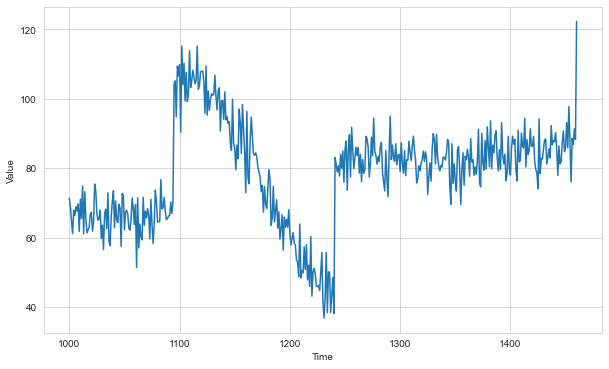

In [66]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series()